### Pig grunts audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split, KFold
from pprint import pprint
from collections import defaultdict



#from torchvision import transforms


from model_v2 import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# directory_path = os.path.join(os.getcwd(), 'Dataset')
# # directory_path = os.getcwd()

# # Get the list of all contents in the directory (all audio files)
# contents = os.listdir(directory_path)
# print(f"Contents of the directory '{directory_path}':")
# file_paths = []
# for item in tqdm(contents):
#     file_path = os.path.join(directory_path, item)  # Full path to the file
#     file_paths.append(file_path)
#     wvf, sample_rate = torchaudio.load(file_path)
#     print(f"Loaded: {item} | Sample Rate: {sample_rate} | Shape: {wvf.shape}")
# #     break

In [ ]:
# labels = []
# for element in tqdm(file_paths):
#     name = element[:-4]
#     label = int(name[-1])
#     labels.append(label)


In [4]:
# set all the parameters

data_path = os.path.join(os.getcwd(), 'Dataset')

fixed_sample_rate = 48000 #16000
num_samples = 98000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 60 #64
n_mfcc = 60


transfo_mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        normalized=True,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk")

transfo_mfcc = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        log_mels=False)

transfo_spectro = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length = hop_length,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        onesided=True,
        return_complex=None)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:
# choose which transformation to apply to the waveforms + adjust necessary parameters/variables :

transfo_applied = 'spectrogram'
# transfo_applied = 'mel_spectrogram'
# transfo_applied = 'mfcc'


if transfo_applied == 'spectrogram':
    transformation = transfo_spectro
    cnn = CNN_spectro()
    best_model = CNN_spectro()
    random_tensor = torch.rand([64,1,513,192]).to(device)

elif transfo_applied == 'mel_spectrogram' :
    transformation = transfo_mel
    cnn = CNN_mel()
    best_model = CNN_mel()
    random_tensor = torch.rand([64,1,60,192]).to(device)

elif transfo_applied == 'mfcc':
    transformation = transfo_mfcc
    cnn = CNN_mfcc()
    best_model = CNN_mfcc()
    random_tensor = torch.rand([64,1,60,491]).to(device)


In [6]:
# Create the custom dataset class + apply transformation to the data
    
class PigsAudioDataset(Dataset):
    def __init__(self, data_path, transformation, target_sample_rate, nr_samples):

        self.audio_dir = data_path
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        
    def __len__(self):
        folder_contents = os.listdir(self.audio_dir)
        return len(folder_contents)

    def __getitem__(self, idx):
        
        list_audio_paths, audio_path = self._get_audio_paths(self.audio_dir, idx)
        label = self._get_label(list_audio_paths, idx)
        
        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        waveform = self._resample(waveform, sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
#         waveform = self._normalize(waveform)  # Apply normalization
        transfo = self.transformation(waveform)
        
        return waveform, sample_rate, label, transfo


    def _get_audio_paths(self, directory_path, idx):
        # Get the list of all contents (files and directories) in the directory
        contents = os.listdir(directory_path)
        file_paths = []
        for item in contents:
            file_path = os.path.join(directory_path, item)  # Full path to the file
            file_paths.append(file_path)

        return file_paths, file_paths[idx]
    
    def _get_label(self, file_paths, idx):
        
        labels = []
        for element in file_paths:
            name = element[:-4]
            label = int(name[-1])
            labels.append(label)
        
        return labels[idx]


    def _resample(self, wvf, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf

    def _trim(self, wvf):
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf

    def _zero_pad(self, wvf):
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf
    
    def _normalize(self, wvf):
        # Min-max scaling to range [0, 1]
        min_val = torch.min(wvf)
        max_val = torch.max(wvf)
        normalized_wvf = (wvf - min_val) / (max_val - min_val)
        return normalized_wvf



In [8]:
# Create an instance of the dataset
dataset = PigsAudioDataset(data_path, transformation, fixed_sample_rate, num_samples)

In [11]:
k_folds = 5
results = {}
generator = torch.manual_seed(453)

# 2 distinct datasets : train with kfolds and hold-out test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)


In [12]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print(f'total length : {len(dataset)}')

nr of observations in train set : 1397
nr of observations in test set : 349
total length : 1746


FOLD 0
--------------------------------
length train_dataset fold n.0 : 1117


1117it [00:47, 23.36it/s]


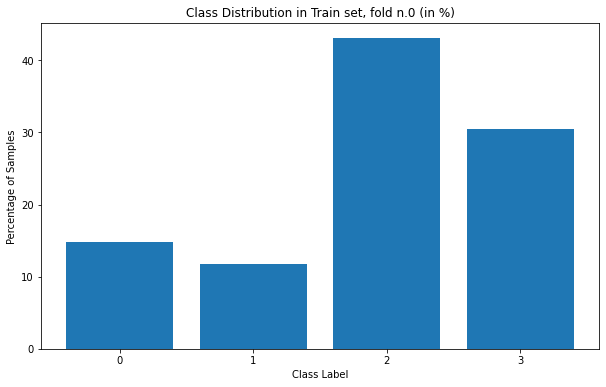

{0: 15, 1: 12, 2: 43, 3: 30}
length val_dataset fold n.0 : 280


280it [00:11, 23.53it/s]


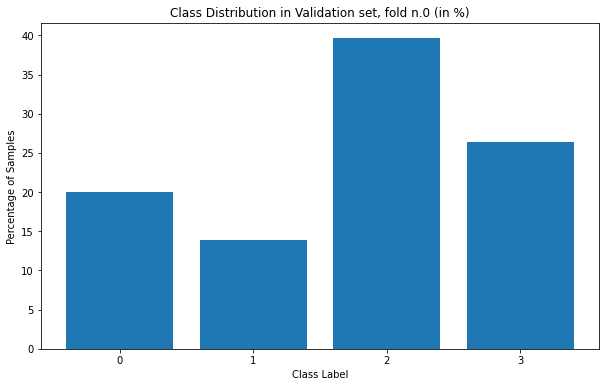

{0: 20, 1: 14, 2: 40, 3: 26}
FOLD 1
--------------------------------
length train_dataset fold n.1 : 1117


1117it [00:47, 23.72it/s]


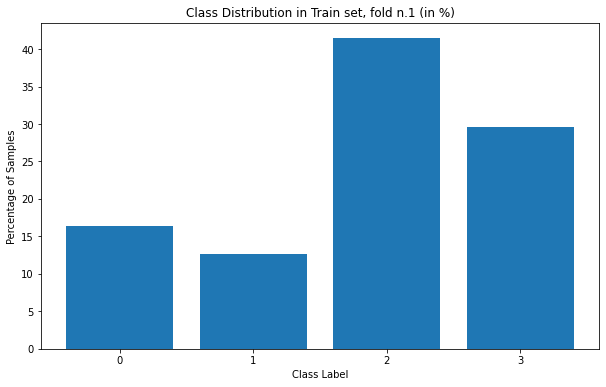

{0: 16, 1: 13, 2: 41, 3: 30}
length val_dataset fold n.1 : 280


280it [00:12, 23.09it/s]


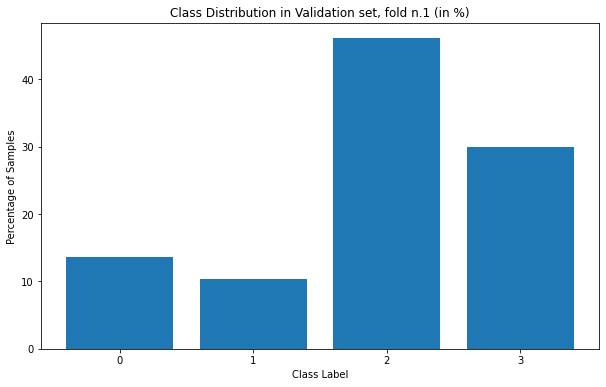

{0: 14, 1: 10, 2: 46, 3: 30}
FOLD 2
--------------------------------
length train_dataset fold n.2 : 1118


1118it [00:47, 23.49it/s]


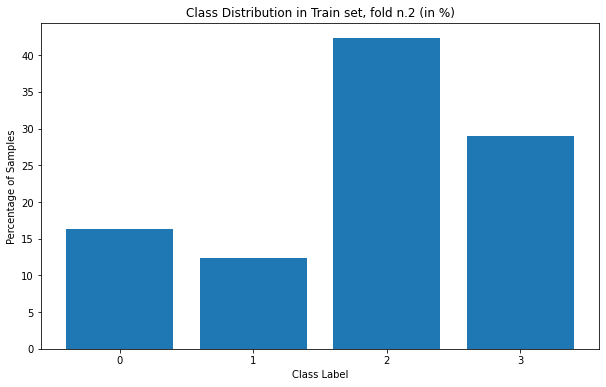

{0: 16, 1: 12, 2: 42, 3: 29}
length val_dataset fold n.2 : 279


279it [00:12, 23.08it/s]


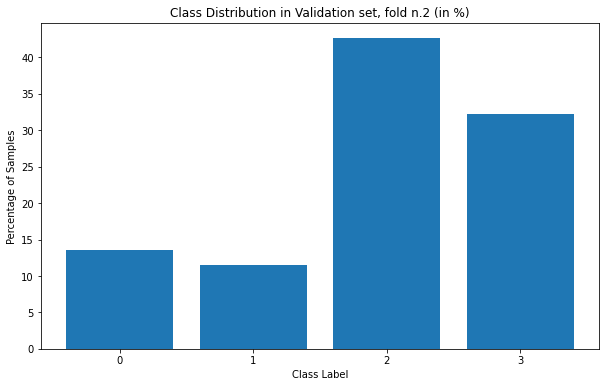

{0: 14, 1: 11, 2: 43, 3: 32}
FOLD 3
--------------------------------
length train_dataset fold n.3 : 1118


1118it [00:47, 23.49it/s]


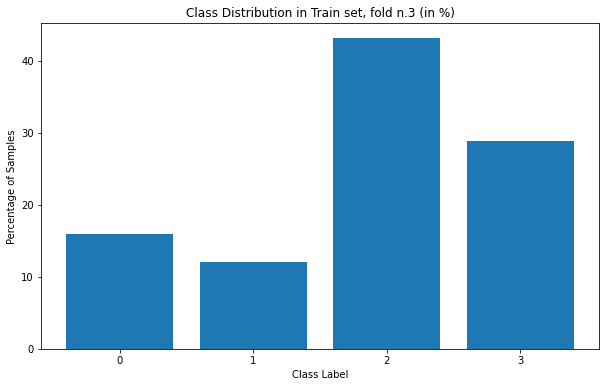

{0: 16, 1: 12, 2: 43, 3: 29}
length val_dataset fold n.3 : 279


279it [00:12, 23.16it/s]


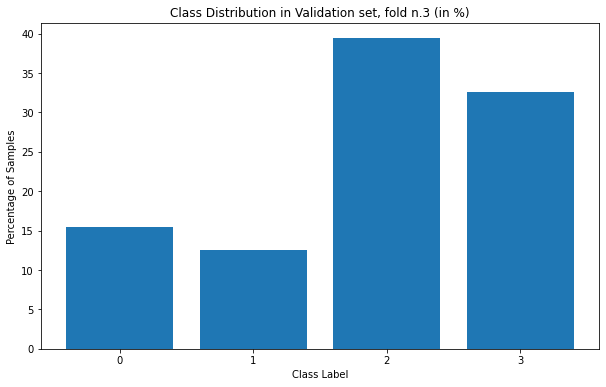

{0: 15, 1: 13, 2: 39, 3: 33}
FOLD 4
--------------------------------
length train_dataset fold n.4 : 1118


1118it [00:47, 23.36it/s]


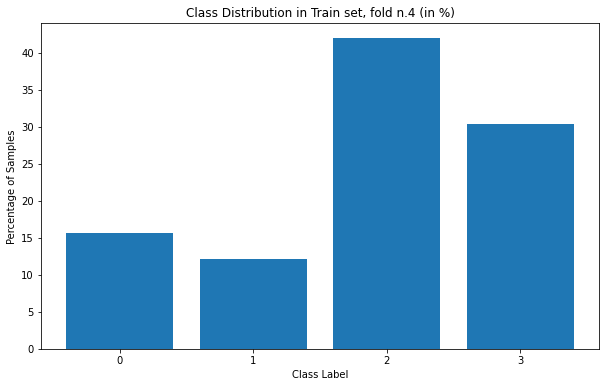

{0: 16, 1: 12, 2: 42, 3: 30}
length val_dataset fold n.4 : 279


279it [00:11, 23.26it/s]


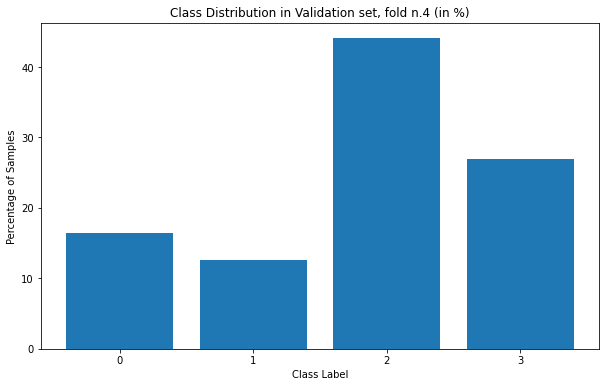

{0: 16, 1: 13, 2: 44, 3: 27}


In [14]:
k_folds = 5
results = {}

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)


batch_size = 32


for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.Subset(train_dataset, train_ids)
    val_subsampler = torch.utils.data.Subset(train_dataset, val_ids)
    
   
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_subsampler, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subsampler,
                      batch_size=batch_size)
    
    train_set = trainloader.dataset
    print(f"length train_dataset fold n.{fold} : {len(trainloader.dataset)}")
    class_distrib(train_set, f"Train set, fold n.{fold}")
    val_set = valloader.dataset
    print(f"length val_dataset fold n.{fold} : {len(valloader.dataset)}")
    class_distrib(val_set, f"Validation set, fold n.{fold}")

1746it [00:28, 61.06it/s]


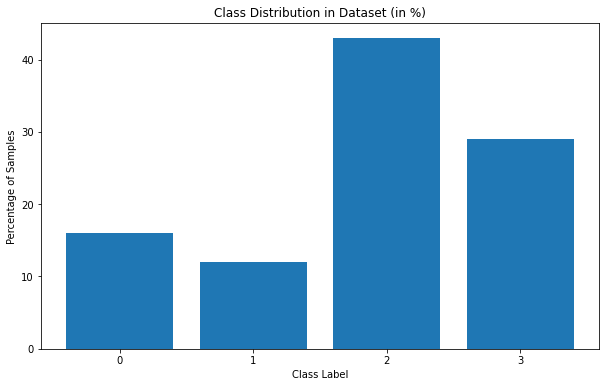

{0: 16, 1: 12, 2: 43, 3: 29}


In [19]:
# Class distribution of the entire dataset

class_distribution_percent, class_weights = class_distrib(dataset, 'Dataset')

262it [00:04, 59.44it/s]


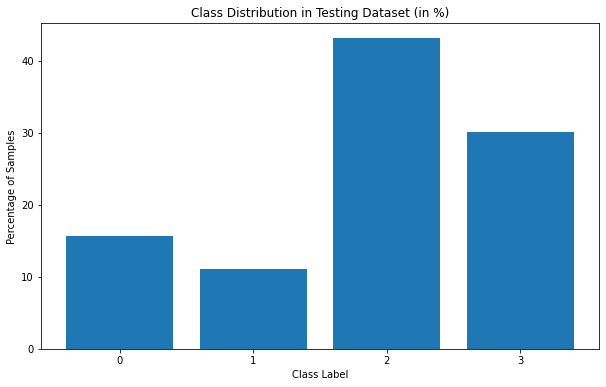

{0: 16, 1: 11, 2: 43, 3: 30}


261it [00:04, 59.17it/s]


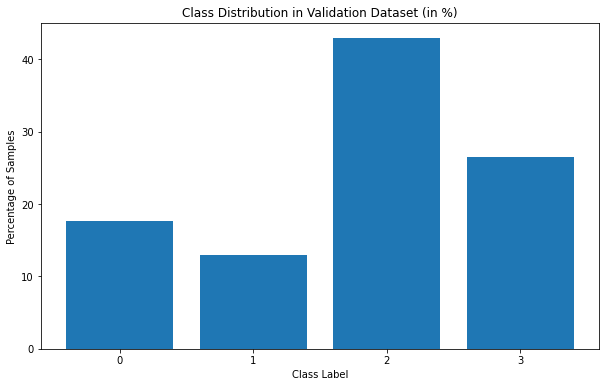

{0: 18, 1: 13, 2: 43, 3: 26}


1223it [00:22, 55.05it/s]


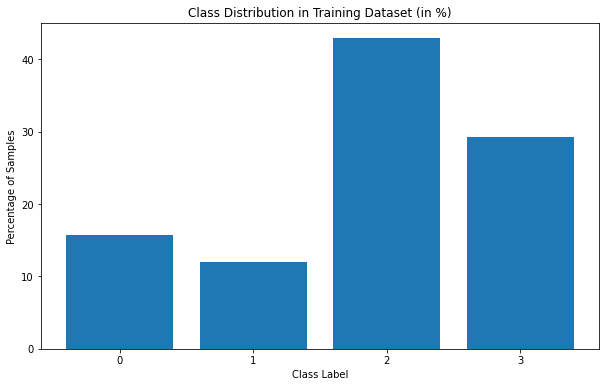

{0: 16, 1: 12, 2: 43, 3: 29}


In [46]:
# # Check if the dataset is balanced over all the classes in the different subsets

# class_distribution_percent_test, class_weights_test = class_distrib(test_dataset, 'Testing Dataset')
# class_distribution_percent_val, class_weights_val = class_distrib(val_dataset, 'Validation Dataset')
# class_distribution_percent_train, class_weights_train = class_distrib(train_dataset, 'Training Dataset')


In [48]:
# # Convert the class_weights dictionary to a tensor (for the loss)

# class_weights_train_tensor = class_weights_tensor(class_weights_train, device)
# class_weights_test_tensor = class_weights_tensor(class_weights_test, device)
# class_weights_val_tensor = class_weights_tensor(class_weights_val, device)

Dataset train - Number of Samples: 1485
Dataset test - Number of Samples: 261


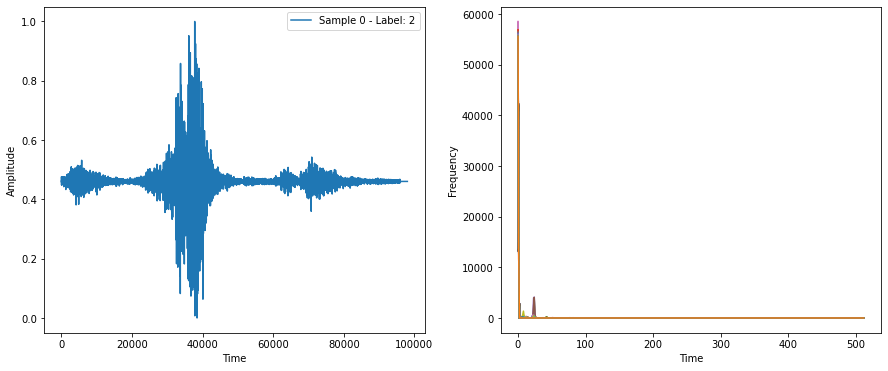

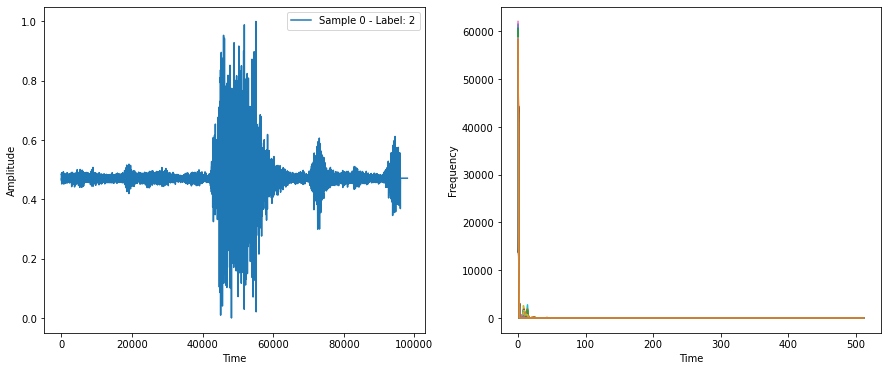

In [13]:
# see what's inside (plot waveforms and mel_spectrograms)
number_of_samples = 1
dataset_names = ["train", "test"]
datasets = [train_dataset, test_dataset]

for dataset, dataset_name in zip(datasets, dataset_names):

    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")

    plt.clf()
    plt.title(f"Dataset {dataset_name}")

    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, _ = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, transform = dataset[i]
        ax.plot(transform.squeeze(), label=f"Sample {i} - Label: {label}")
#        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


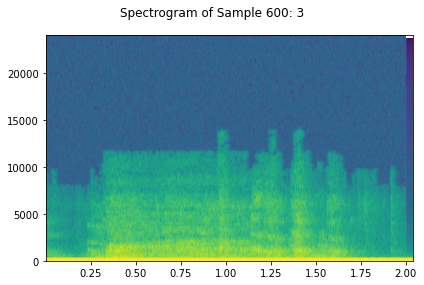

In [14]:
i = 600
waveform, sample_rate, label, _ = train_dataset[i]
plot_specgram(waveform, sample_rate, title=f"Spectrogram of Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

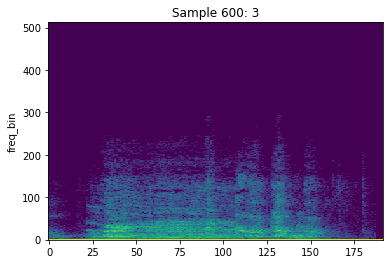

In [77]:
i = 600
waveform, sample_rate, label, _ = train_dataset[i]
plot_spectrogram(torchaudio.transforms.Spectrogram(n_fft=n_fft)(waveform).squeeze(), title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)


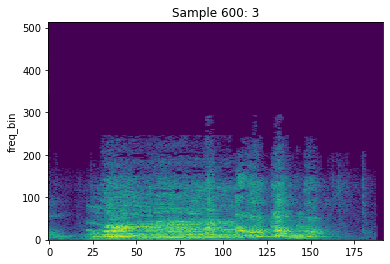

In [47]:
# Same as before
i = 600
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


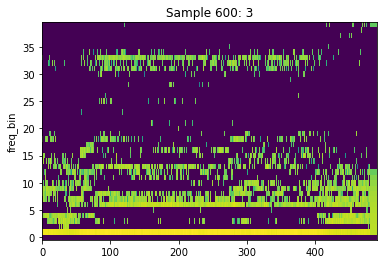

In [22]:
# Same as before
i = 600
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


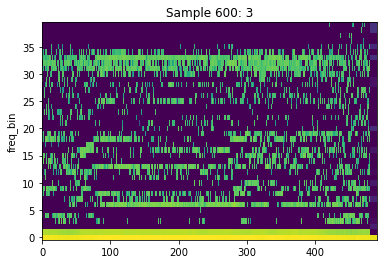

In [49]:
# Same as before
i = 600
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


In [15]:
# def reset_weights(m):
#     '''
#     Try resetting model weights to avoid
#     weight leakage.
#     '''
#     for layer in m.children():
#         if hasattr(layer, 'reset_parameters'):
# #             print(f'Reset trainable parameters of layer = {layer}')
#             layer.reset_parameters()


In [16]:
batch_size = 32
n_epochs = 20
current_datetime = datetime.now()
date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'
patience=5
min_improvement=0.00

best_model_state_overall = None


print('--------------------------------')

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subset = torch.utils.data.Subset(train_dataset, train_ids)
    val_subset = torch.utils.data.Subset(train_dataset, val_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_subset, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subset,
                      batch_size=batch_size)
    
    # Init the neural network
    if transfo_applied == 'mel_spectrogram' :
        model = CNN_mel()
    elif transfo_applied == 'mfcc':
        model = CNN_mfcc()
    elif transfo_applied == 'spectrogram':
        model = CNN_spectro()

    train_criterion = nn.CrossEntropyLoss()
    val_criterion = nn.CrossEntropyLoss()

    model.to(device)
    model.apply(reset_weights)
    
    # Initialize optimizer
    optim = torch.optim.Adam(model.parameters(),lr=0.001)


   # Run the training loop for defined number of epochs      
    counter = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss_overall = float('inf')

    for epoch in range(n_epochs):
        
        # Print epoch
        print(f'Starting epoch {epoch}')

        train_loss, train_accuracy = train_epoch(model, trainloader, optim, train_criterion, device, epoch, train_losses, train_accuracies)

        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            val_total = 0
        
            for i, (wf, sr, labels, transform) in enumerate(valloader):
                
                transform, labels = transform.to(device), labels.to(device)
                preds = model(transform)
                val_loss += val_criterion(preds, labels).item()

                _, predicted = preds.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
            average_val_loss = val_loss / len(valloader)
            val_accuracy = val_correct * 100.0 / val_total 

            val_losses.append(average_val_loss)
            val_accuracies.append(val_accuracy)

            model.train()
            
            # Check if validation loss has improved
            if best_val_loss_overall - val_loss > min_improvement:
                best_val_loss_overall = val_loss
                counter = 0
                best_model_state_overall = model.state_dict()
            else:
                counter += 1

            if counter >= patience:
                print("Early stopping! No improvement for", patience, "epochs (fold n.)", fold,".")
                break
            
        print(f"epoch n.{epoch} : Val Average Loss = {average_val_loss}, Val Accuracy = {val_accuracy:.2f}%")



    correct, total = 0, 0
    with torch.no_grad():
        for i, (wf, sr, labels, transform) in enumerate(valloader): 
            transform, labels = transform.to(device), labels.to(device)
            preds = model(transform)
            _, predicted = preds.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
                

        # Print accuracy over all fold
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)
         


# Save the best model state overall after all folds
# needs to be redone bc it saves the best model of the last fold
if best_model_state_overall is not None:
    torch.save(best_model_state_overall, "best_model.pth")


# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')


    
# Return the learning curves
#train_losses, train_accuracies, val_losses, val_accuracies

--------------------------------
FOLD 0
--------------------------------
Starting epoch 0
Train Epoch: 0 [0/1117 (0%)]	Loss: 1.354711
Train Epoch: 0 [320/1117 (29%)]	Loss: 1.207454
Train Epoch: 0 [640/1117 (57%)]	Loss: 1.303375
Train Epoch: 0 [960/1117 (86%)]	Loss: 1.313012
epoch n.0 : Average Loss = 1.292009196962629, Accuracy = 41.27%
epoch n.0 : Val Average Loss = 1.3095060057110257, Val Accuracy = 41.07%
Starting epoch 1
Train Epoch: 1 [0/1117 (0%)]	Loss: 1.385457
Train Epoch: 1 [320/1117 (29%)]	Loss: 1.224992
Train Epoch: 1 [640/1117 (57%)]	Loss: 1.288501
Train Epoch: 1 [960/1117 (86%)]	Loss: 1.341579
epoch n.1 : Average Loss = 1.2791724920272827, Accuracy = 41.99%
epoch n.1 : Val Average Loss = 1.3045328458150227, Val Accuracy = 41.07%
Starting epoch 2
Train Epoch: 2 [0/1117 (0%)]	Loss: 1.416767
Train Epoch: 2 [320/1117 (29%)]	Loss: 1.180800
Train Epoch: 2 [640/1117 (57%)]	Loss: 1.256474
Train Epoch: 2 [960/1117 (86%)]	Loss: 1.310040
epoch n.2 : Average Loss = 1.2380870478493826,

Train Epoch: 3 [960/1117 (86%)]	Loss: 1.133402
epoch n.3 : Average Loss = 0.9986787915229798, Accuracy = 59.27%
epoch n.3 : Val Average Loss = 0.9771506057845222, Val Accuracy = 59.64%
Starting epoch 4
Train Epoch: 4 [0/1117 (0%)]	Loss: 1.138880
Train Epoch: 4 [320/1117 (29%)]	Loss: 0.791221
Train Epoch: 4 [640/1117 (57%)]	Loss: 0.880677
Train Epoch: 4 [960/1117 (86%)]	Loss: 1.022081
epoch n.4 : Average Loss = 0.8871359280177525, Accuracy = 65.98%
Early stopping! No improvement for 5 epochs (fold n.) 1 .
Accuracy for fold 1: 59 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 0
Train Epoch: 0 [0/1118 (0%)]	Loss: 1.395815
Train Epoch: 0 [320/1118 (29%)]	Loss: 1.282253
Train Epoch: 0 [640/1118 (57%)]	Loss: 1.287836
Train Epoch: 0 [960/1118 (86%)]	Loss: 1.232173
epoch n.0 : Average Loss = 1.2930122137069702, Accuracy = 40.79%
epoch n.0 : Val Average Loss = 1.3063874906963773, Val Accuracy = 42.29%
Starting epoch 1
Train Epoch: 1 [0/1118 (0%)]	Loss:

In [ ]:

# #                 ### test ###
# #                 acc = [0 for c in list_of_classes]
# #                 for c in list_of_classes:
# #                     acc[c] = (((preds == labels) * (labels == c)).float().sum() / (max(labels == c).sum(), 1))
#                 #print(classification_report(labels, predicted))
# #                 # Calculate class accuracies
# #                 class_corrects, class_totals, class_accs = compute_class_accuracies(preds, labels)
# #                 # Print or log class accuracies
# #                 print(f'Class corrects : {class_corrects}, class totals : {class_totals}, Class accuracies: {class_accs}')
# #                 ### test ###


In [17]:
# # load the data into DataLoaders
# batch_size = 32
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_criterion = nn.CrossEntropyLoss()

# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [78]:
# After training, to load the best model for inference or evaluation

if transfo_applied == 'mel_spectrogram' :
    best_model = CNN_mel()
elif transfo_applied == 'mfcc':
    best_model = CNN_mfcc()
elif transfo_applied == 'spectrogram':
    best_model = CNN_spectro()


state_dict = torch.load("best_model.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

CNN_spectro(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3776, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Soft

In [21]:
# test on an independant sample :
test_loss, test_accuracy = test_model(best_model, test_dataloader, test_criterion, device)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.60s/it]


Test set: Average loss: 0.0471, Accuracy: 87/349 (24.9%)



In [99]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(best_model, input_data, target)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : 2, Expected label : 2


In [74]:
# if transfo_applied == 'mel_spectrogram' :
#     cnn = CNN_mel()
# elif transfo_applied == 'mfcc':
#     cnn = CNN_mfcc()
# elif transfo_applied == 'spectrogram':
#     cnn = CNN_spectro()

# cnn.to(device)

# # train_criterion = nn.CrossEntropyLoss(weight=class_weights_train_tensor)
# # test_criterion = nn.CrossEntropyLoss(weight=class_weights_test_tensor)
# # val_criterion = nn.CrossEntropyLoss(weight=class_weights_val_tensor)


# train_criterion = nn.CrossEntropyLoss()
# test_criterion = nn.CrossEntropyLoss()
# val_criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)

In [72]:
# Model summary
input_size = train_dataset[0][3].shape
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 38, 489]              80
              ReLU-2           [-1, 8, 38, 489]               0
         MaxPool2d-3           [-1, 8, 19, 244]               0
            Conv2d-4          [-1, 16, 15, 240]           3,216
              ReLU-5          [-1, 16, 15, 240]               0
         MaxPool2d-6           [-1, 16, 7, 120]               0
            Conv2d-7           [-1, 32, 5, 118]           4,640
              ReLU-8           [-1, 32, 5, 118]               0
         MaxPool2d-9            [-1, 32, 2, 59]               0
          Flatten-10                 [-1, 3776]               0
           Linear-11                  [-1, 128]         483,456
           Linear-12                   [-1, 64]           8,256
           Linear-13                    [-1, 4]             260
          Softmax-14                   

In [18]:
# try with a random tensor of the right dimensions
model(random_tensor)[0]

tensor([ 3.8887, -1.9302,  0.4165, -2.2253], grad_fn=<SelectBackward0>)

In [71]:
# # train the network

# n_epochs = 20
# current_datetime = datetime.now()
# date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
# saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'

# train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(cnn, train_dataloader, val_dataloader, optimizer, train_criterion, val_criterion, device, n_epochs, saving_path)

Train Epoch: 0 [0/1223 (0%)]	Loss: 1.364794
Train Epoch: 0 [320/1223 (26%)]	Loss: 1.166690
Train Epoch: 0 [640/1223 (51%)]	Loss: 0.793487
Train Epoch: 0 [960/1223 (77%)]	Loss: 0.697031
epoch n.0 : Average Loss = 0.8977756026463631, Accuracy = 64.02%
epoch n.0 : Val Average Loss = 0.5928451418876648, Val Accuracy = 71.26%
Train Epoch: 1 [0/1223 (0%)]	Loss: 0.557768
Train Epoch: 1 [320/1223 (26%)]	Loss: 0.492186
Train Epoch: 1 [640/1223 (51%)]	Loss: 0.617651
Train Epoch: 1 [960/1223 (77%)]	Loss: 0.233154
epoch n.1 : Average Loss = 0.47614768109260464, Accuracy = 82.42%
epoch n.1 : Val Average Loss = 0.39738894005616504, Val Accuracy = 82.76%
Train Epoch: 2 [0/1223 (0%)]	Loss: 0.223895
Train Epoch: 2 [320/1223 (26%)]	Loss: 0.571594
Train Epoch: 2 [640/1223 (51%)]	Loss: 0.482149
Train Epoch: 2 [960/1223 (77%)]	Loss: 0.409316
epoch n.2 : Average Loss = 0.3606864355313472, Accuracy = 86.84%
epoch n.2 : Val Average Loss = 0.3346836715936661, Val Accuracy = 86.59%
Train Epoch: 3 [0/1223 (0%)]	

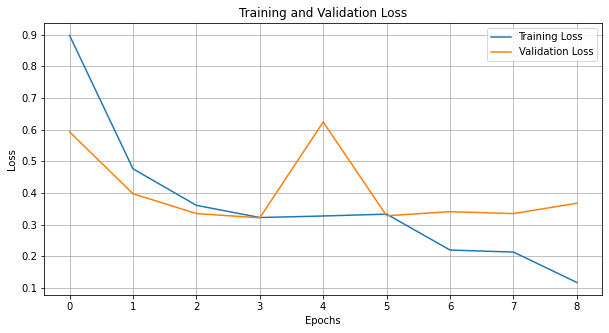

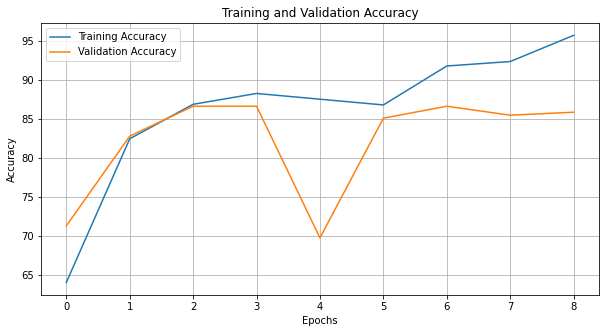

In [72]:
# plot learning curves

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/losses_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, bbox_inches='tight', pad_inches=0.15,facecolor='white', transparent=False)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/accuracies_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=2)
plt.show()


- Quand faut-il faire de la segmentation ?
- Si nombre de samples =/= (taille d'échant =/=) : trim ou pad, mais on peut aussi stretch ?
- Quand faut-il mieux utiliser une transformation en MelSpectrograms ou en mfcc ?
- Rajouter nn.Dropout() après chaque couche ?
- scheduler ?

- NORMALISATION / BATCH NORMALISATION ?